In [1]:
import scvi
import anndata
import scanpy as sc
from scipy.io import mmread
import pandas as pd
import optuna

C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSRDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSRDataset 

In [2]:
import torch
print(torch.cuda.is_available())

True


In [12]:
# Load the data into an AnnData object
# Assuming matrix.mtx contains the gene expression data, features.tsv has genes, and barcodes.tsv has cell barcodes
CO_STR_gene_expression_matrix = mmread("../../../../CO_STR.scp.raw.mtx").tocsc()  # Sparse matrix format

CO_EPI_gene_expression_matrix = mmread("../../../../CO_EPI.scp.raw.mtx").tocsc()  # Sparse matrix format

CO_IMM_gene_expression_matrix = mmread("../../../../CO_IMM.scp.raw.mtx").tocsc()  # Sparse matrix format


In [13]:
# Load gene names and cell barcodes
with open("../../../../CO_STR.scp.features.tsv") as f:
    CO_STR_gene_names = [line.strip().split()[0] for line in f]
with open("../../../../CO_STR.scp.barcodes.tsv") as f:
    CO_STR_cell_barcodes = [line.strip().split()[0] for line in f]

with open("../../../../CO_EPI.scp.features.tsv") as f:
    CO_EPI_gene_names = [line.strip().split()[0] for line in f]
with open("../../../../CO_EPI.scp.barcodes.tsv") as f:
    CO_EPI_cell_barcodes = [line.strip().split()[0] for line in f]

with open("../../../../CO_IMM.scp.features.tsv") as f:
    CO_IMM_gene_names = [line.strip().split()[0] for line in f]
with open("../../../../CO_IMM.scp.barcodes.tsv") as f:
    CO_IMM_cell_barcodes = [line.strip().split()[0] for line in f]
    
# Create the AnnData object
CO_STR_adata = anndata.AnnData(CO_STR_gene_expression_matrix.T, var={"gene_names": CO_STR_gene_names}, obs={"cell_barcodes": CO_STR_cell_barcodes})
CO_STR_adata.var_names = CO_STR_gene_names

CO_EPI_adata = anndata.AnnData(CO_EPI_gene_expression_matrix.T, var={"gene_names": CO_EPI_gene_names}, obs={"cell_barcodes": CO_EPI_cell_barcodes})
CO_EPI_adata.var_names = CO_EPI_gene_names

CO_IMM_adata = anndata.AnnData(CO_IMM_gene_expression_matrix.T, var={"gene_names": CO_IMM_gene_names}, obs={"cell_barcodes": CO_IMM_cell_barcodes})
CO_IMM_adata.var_names = CO_IMM_gene_names

In [14]:
# Load metadata containing cell type information
metadata = pd.read_csv("../../../../scp_metadata_combined.v2.txt", sep="\t")

# Set the index to match the cell barcodes in AnnData for easy mapping
metadata = metadata.set_index("NAME")

# Add labels to the AnnData object
CO_STR_adata.obs["Celltype"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["Celltype"])
CO_STR_adata.obs["disease__ontology_label"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["disease__ontology_label"])
CO_STR_adata.obs["donor_id"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["donor_id"]).astype('category')
CO_STR_adata.obs["donor_id"] = CO_STR_adata.obs["donor_id"].astype(str)
CO_STR_adata.obs["library_preparation_protocol__ontology_label"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["library_preparation_protocol__ontology_label"]).astype('category')
CO_STR_adata.obs["library_preparation_protocol__ontology_label"] = CO_STR_adata.obs["library_preparation_protocol__ontology_label"].astype(str)
CO_STR_adata.obs["Type"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["Type"]).astype('category')
CO_STR_adata.obs["Type"] = CO_STR_adata.obs["Type"].astype(str)
CO_STR_adata.obs["batch"] = CO_STR_adata.obs["donor_id"] + "_" + CO_STR_adata.obs["library_preparation_protocol__ontology_label"]

CO_EPI_adata.obs["Celltype"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["Celltype"])
CO_EPI_adata.obs["disease__ontology_label"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["disease__ontology_label"])
CO_EPI_adata.obs["donor_id"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["donor_id"]).astype('category')
CO_EPI_adata.obs["donor_id"] = CO_EPI_adata.obs["donor_id"].astype(str)
CO_EPI_adata.obs["Type"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["Type"]).astype('category')
CO_EPI_adata.obs["Type"] = CO_EPI_adata.obs["Type"].astype(str)
CO_EPI_adata.obs["library_preparation_protocol__ontology_label"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["library_preparation_protocol__ontology_label"]).astype('category')
CO_EPI_adata.obs["library_preparation_protocol__ontology_label"] = CO_EPI_adata.obs["library_preparation_protocol__ontology_label"].astype(str)
CO_EPI_adata.obs["batch"] = CO_EPI_adata.obs["donor_id"] + "_" + CO_EPI_adata.obs["library_preparation_protocol__ontology_label"]

CO_IMM_adata.obs["Celltype"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["Celltype"])
CO_IMM_adata.obs["disease__ontology_label"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["disease__ontology_label"])
CO_IMM_adata.obs["donor_id"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["donor_id"]).astype('category')
CO_IMM_adata.obs["donor_id"] = CO_IMM_adata.obs["donor_id"].astype(str)
CO_IMM_adata.obs["Type"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["Type"]).astype('category')
CO_IMM_adata.obs["Type"] = CO_IMM_adata.obs["Type"].astype(str)
CO_IMM_adata.obs["library_preparation_protocol__ontology_label"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["library_preparation_protocol__ontology_label"]).astype('category')
CO_IMM_adata.obs["library_preparation_protocol__ontology_label"] = CO_IMM_adata.obs["library_preparation_protocol__ontology_label"].astype(str)
CO_IMM_adata.obs["batch"] = CO_IMM_adata.obs["donor_id"] + "_" + CO_IMM_adata.obs["library_preparation_protocol__ontology_label"]


C:\Users\Chan_\AppData\Local\Temp\ipykernel_3136\164065289.py:2: DtypeWarning: Columns (2,3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../../../../scp_metadata_combined.v2.txt", sep="\t")


In [29]:

from sklearn.metrics import adjusted_rand_score
import optuna
import scvi
import scanpy as sc
import torch
import copy
import pickle

def objective(trial):
    # Create a copy of the original AnnData object for this trial
    adata = copy.deepcopy(CO_STR_adata)
    
    # Suggest hyperparameters
    n_hidden = trial.suggest_int("n_hidden", 32, 256, step=32)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # latent_dim = trial.suggest_int("latent_dim", 5, 50)
    # lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    
    # Set up scVI with the suggested batch size
    scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

    # Initialize the SCVI model with the suggested parameters
    vae = scvi.model.SCVI(
        adata,
        n_latent=5,
        n_hidden=n_hidden,
        n_layers=n_layers
    )
    
    # Train the model
    scvi.settings.dl_num_workers = 0  # For Windows compatibility
    scvi.settings.dl_persistent_workers = False
    vae.train(
        max_epochs=100,
        plan_kwargs={"lr": 0.0001184620238284258},
        accelerator="gpu",
        early_stopping=True,
        early_stopping_monitor="elbo_train",  # Monitor evidence lower bound
        early_stopping_patience=10  # Stop if no improvement after 10 epochs
    )
    
    # Evaluate clustering quality using Adjusted Rand Index (ARI)
    adata.uns.pop("neighbors", None)  # Reset neighbors
    adata.obsm.pop("X_umap", None)  # Reset UMAP if it exists
    latent = vae.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.louvain(adata, resolution=0.5)
    
    # Drop NaN values for ARI calculation
    valid_cells = ~adata.obs["Celltype"].isna()
    ari = adjusted_rand_score(
        adata.obs["Celltype"][valid_cells],
        adata.obs["louvain"][valid_cells]
    )
    
    return ari  # Maximize ARI


# Run the hyperparameter optimization
CO_STR_study = optuna.create_study(direction="maximize")
CO_STR_study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Print the best hyperparameters
best_params = CO_STR_study.best_params
print("Best hyperparameters:", best_params)

# Save the study to a pickle file
with open("CO_STR_study_combined_batch_tuned.pkl", "wb") as f:
    pickle.dump(CO_STR_study, f)

# Set up scVI with the best parameters
scvi.model.SCVI.setup_anndata(CO_STR_adata, batch_key="batch")

# Train the final model with the best parameters
CO_STR_tuned_vae = scvi.model.SCVI(
    CO_STR_adata,
    n_latent=5,
    n_hidden=best_params["n_hidden"],
    n_layers=best_params["n_layers"]
)
CO_STR_tuned_vae.train(
    max_epochs=400,
    plan_kwargs={"lr": 0.0001184620238284258},
    accelerator="gpu"
)
CO_STR_tuned_vae.save("CO_STR_combined_batch_tuned.model", overwrite=True)


[I 2024-12-02 22:37:21,174] A new study created in memory with name: no-name-e0fda6f7-a93a-46a5-866d-51b33726245e
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-02 22:54:08,231] Trial 0 finished with value: 0.42651742884839344 and parameters: {'n_hidden': 256, 'n_layers': 2}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-02 23:10:29,211] Trial 1 finished with value: 0.36080152833807627 and parameters: {'n_hidden': 96, 'n_layers': 2}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-02 23:26:54,728] Trial 2 finished with value: 0.33476438443113055 and parameters: {'n_hidden': 64, 'n_layers': 5}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-02 23:46:19,552] Trial 3 finished with value: 0.3857696385766105 and parameters: {'n_hidden': 224, 'n_layers': 1}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 00:05:42,819] Trial 4 finished with value: 0.3905088140166506 and parameters: {'n_hidden': 128, 'n_layers': 2}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 00:24:50,608] Trial 5 finished with value: 0.32695446473478723 and parameters: {'n_hidden': 96, 'n_layers': 1}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 00:42:03,837] Trial 6 finished with value: 0.32390266071221613 and parameters: {'n_hidden': 64, 'n_layers': 1}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 01:13:47,548] Trial 7 finished with value: 0.35834011232791196 and parameters: {'n_hidden': 96, 'n_layers': 4}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 01:34:17,580] Trial 8 finished with value: 0.31262046052970044 and parameters: {'n_hidden': 192, 'n_layers': 1}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 01:51:57,669] Trial 9 finished with value: 0.22846771288701587 and parameters: {'n_hidden': 32, 'n_layers': 3}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 02:14:02,312] Trial 10 finished with value: 0.39035482646716557 and parameters: {'n_hidden': 256, 'n_layers': 3}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 02:34:34,795] Trial 11 finished with value: 0.40051001483611764 and parameters: {'n_hidden': 160, 'n_layers': 2}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 02:50:48,699] Trial 12 finished with value: 0.367236394174968 and parameters: {'n_hidden': 192, 'n_layers': 2}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 03:06:01,303] Trial 13 finished with value: 0.36811431043887044 and parameters: {'n_hidden': 160, 'n_layers': 2}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 03:22:37,240] Trial 14 finished with value: 0.3756603123056257 and parameters: {'n_hidden': 256, 'n_layers': 4}. Best is trial 0 with value: 0.42651742884839344.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 03:38:19,724] Trial 15 finished with value: 0.4341251389961327 and parameters: {'n_hidden': 192, 'n_layers': 3}. Best is trial 15 with value: 0.4341251389961327.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 03:55:02,021] Trial 16 finished with value: 0.386414559334872 and parameters: {'n_hidden': 224, 'n_layers': 4}. Best is trial 15 with value: 0.4341251389961327.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 04:10:54,906] Trial 17 finished with value: 0.37299873853137494 and parameters: {'n_hidden': 224, 'n_layers': 3}. Best is trial 15 with value: 0.4341251389961327.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 04:27:09,103] Trial 18 finished with value: 0.3772854167485588 and parameters: {'n_hidden': 192, 'n_layers': 5}. Best is trial 15 with value: 0.4341251389961327.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-03 04:44:45,550] Trial 19 finished with value: 0.36762036754797134 and parameters: {'n_hidden': 256, 'n_layers': 3}. Best is trial 15 with value: 0.4341251389961327.


Best hyperparameters: {'n_hidden': 192, 'n_layers': 3}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [12]:
import pickle

# Load the study from the pickle file
with open("CO_STR_study_combined_batch_tuned.pkl", "rb") as f:
    CO_STR_study = pickle.load(f)
print(f"Best Objective Value: {CO_STR_study.best_value}")

# Load model from disk
CO_STR_tuned_vae = scvi.model.SCVI.load("CO_STR_combined_batch_tuned.model", adata=CO_STR_adata)

Best Objective Value: 0.4341251389961327
INFO     File CO_STR_combined_batch_tuned.model\model.pt already downloaded                                        


C:\ProgramData\anaconda3\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_lo

In [14]:
# Extract the latent space representation for each cell
CO_STR_latent_representation = CO_STR_tuned_vae.get_latent_representation()
CO_STR_adata.obsm["X_scVI"] = CO_STR_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_STR_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_STR_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_STR_adata)


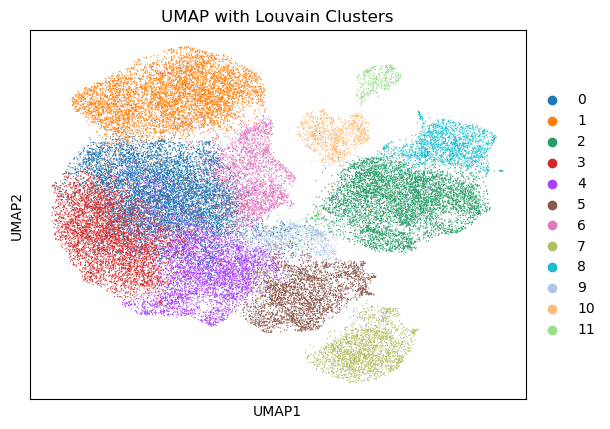

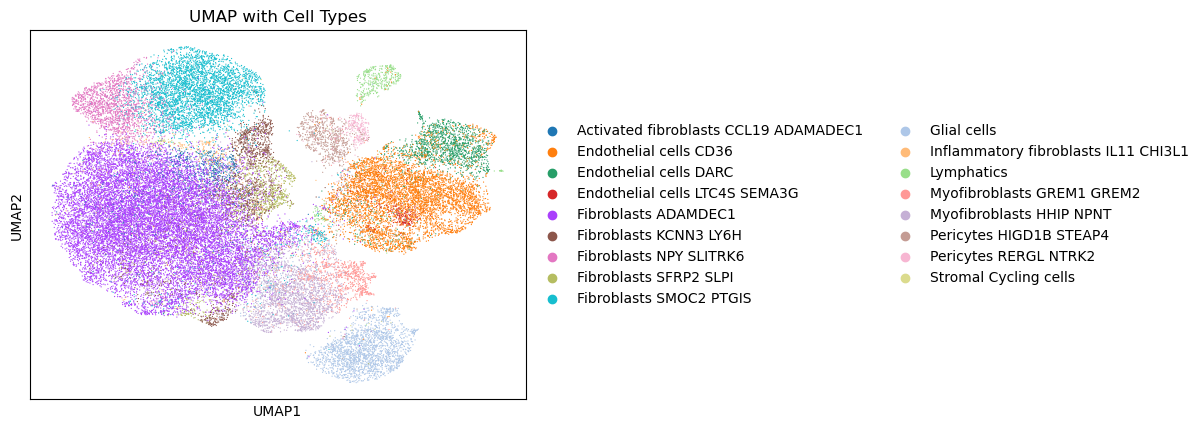

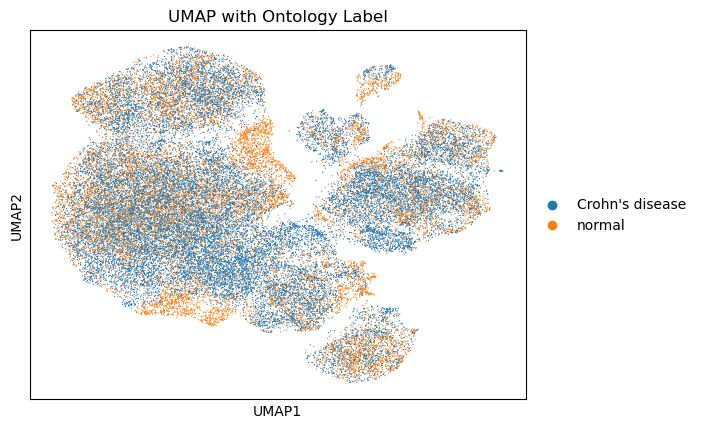

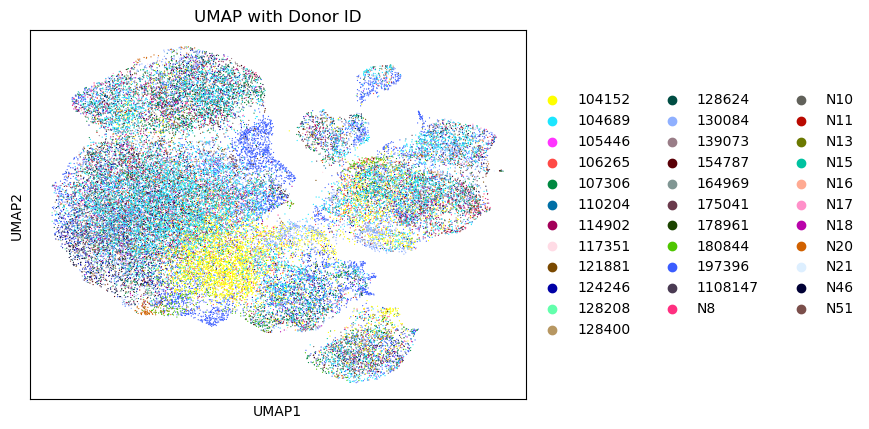

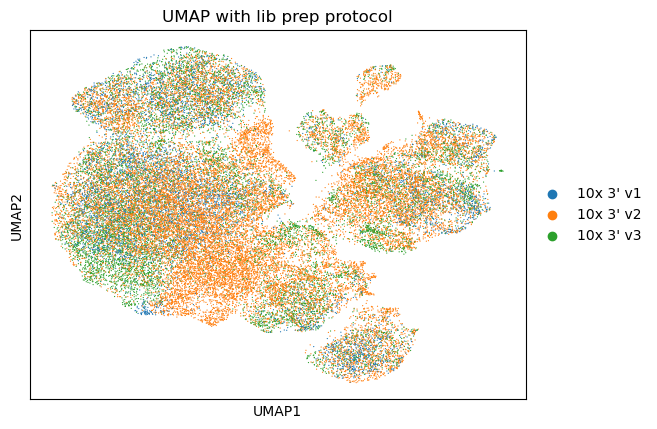

In [34]:
# Plot the clusters
sc.pl.umap(CO_STR_adata, color="louvain", title="UMAP with Louvain Clusters")
sc.pl.umap(CO_STR_adata, color="Celltype", title="UMAP with Cell Types")

# Plot the clusters
sc.pl.umap(CO_STR_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_STR_adata, color="donor_id", title="UMAP with Donor ID")
sc.pl.umap(CO_STR_adata, color="library_preparation_protocol__ontology_label", title="UMAP with lib prep protocol")


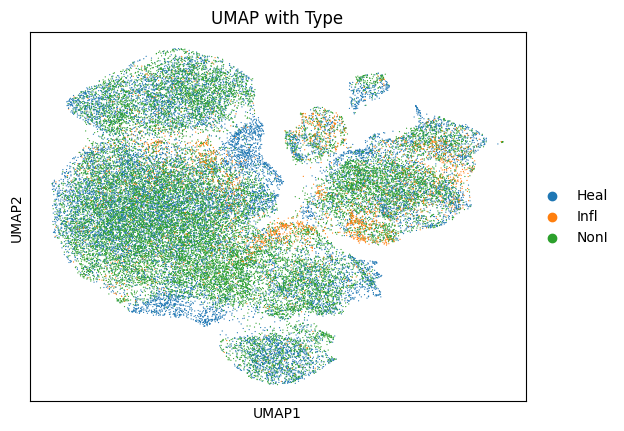

In [17]:
sc.pl.umap(CO_STR_adata, color="Type", title="UMAP with Type")


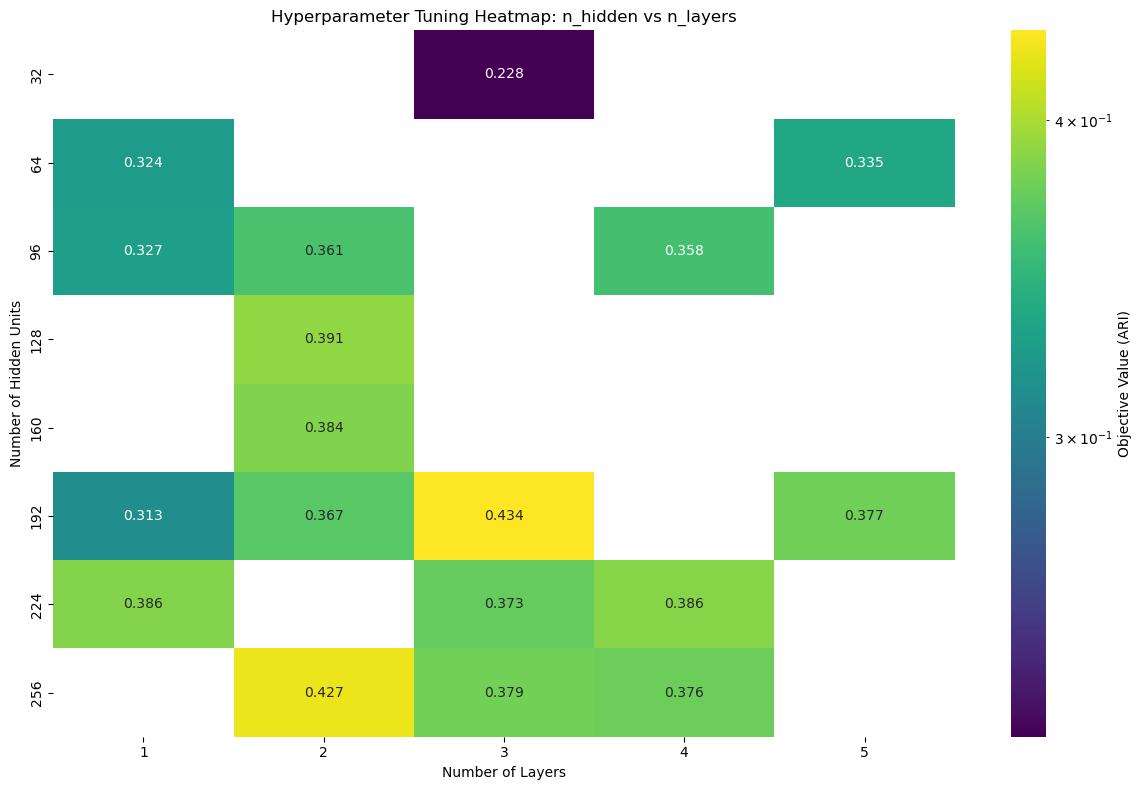

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract data from the Optuna study
data = [
    {
        "n_hidden": trial.params["n_hidden"],
        "n_layers": trial.params["n_layers"],
        "objective_value": trial.value
    }
    for trial in CO_STR_study.trials if trial.value is not None
]

# Convert to a DataFrame
df = pd.DataFrame(data)

# Create a pivot table for the heatmap (e.g., n_hidden vs n_layers)
heatmap_data = df.pivot_table(
    index="n_hidden",  # Rows
    columns="n_layers",  # Columns
    values="objective_value",  # Heatmap values
    aggfunc="mean"  # If duplicates exist, take the average
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="viridis",
    cbar_kws={"label": "Objective Value (ARI)"},
    norm=LogNorm()  # Optional: Logarithmic scale for objective values
)
plt.title("Hyperparameter Tuning Heatmap: n_hidden vs n_layers")
plt.xlabel("Number of Layers")
plt.ylabel("Number of Hidden Units")
plt.tight_layout()
plt.show()


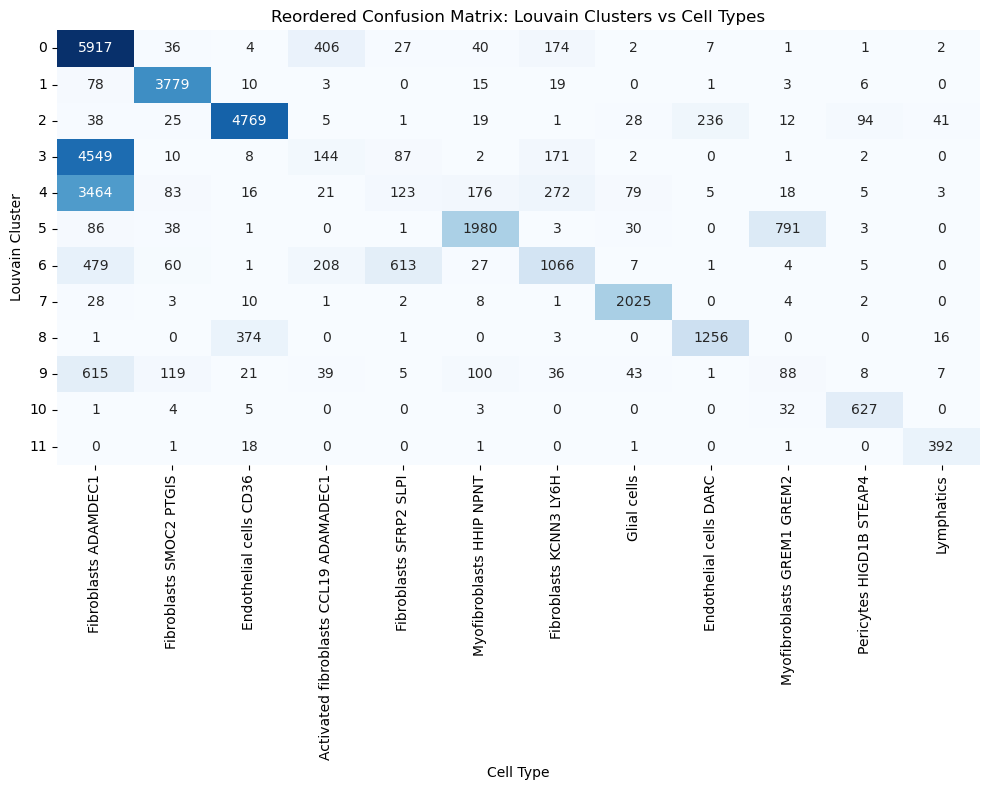

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Create the confusion matrix
conf_matrix = pd.crosstab(CO_STR_adata.obs["louvain"], CO_STR_adata.obs["Celltype"], rownames=["Louvain Cluster"], colnames=["Cell Type"])

# Convert to a numpy array for optimization
matrix = conf_matrix.values

# Use the Hungarian algorithm to find the best alignment
# (linear_sum_assignment minimizes cost, so use negative values for maximization)
row_ind, col_ind = linear_sum_assignment(-matrix)

# Reorder rows and columns of the confusion matrix
ordered_conf_matrix = conf_matrix.iloc[row_ind, col_ind]

# Plot the reordered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Reordered Confusion Matrix: Louvain Clusters vs Cell Types")
plt.xlabel("Cell Type")
plt.ylabel("Louvain Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:

from sklearn.metrics import adjusted_rand_score
import optuna
import scvi
import scanpy as sc
import torch
import copy
import pickle

def objective(trial):
    # Create a copy of the original AnnData object for this trial
    adata = copy.deepcopy(CO_EPI_adata)
    
    # Suggest hyperparameters
    n_hidden = trial.suggest_int("n_hidden", 32, 256, step=32)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # latent_dim = trial.suggest_int("latent_dim", 5, 50)
    # lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    
    # Set up scVI with the suggested batch size
    scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

    # Initialize the SCVI model with the suggested parameters
    vae = scvi.model.SCVI(
        adata,
        n_latent=5,
        n_hidden=n_hidden,
        n_layers=n_layers
    )
    
    # Train the model
    scvi.settings.dl_num_workers = 0  # For Windows compatibility
    scvi.settings.dl_persistent_workers = False
    vae.train(
        max_epochs=100,
        plan_kwargs={"lr": 0.0001184620238284258},
        accelerator="gpu",
        early_stopping=True,
        early_stopping_monitor="elbo_train",  # Monitor evidence lower bound
        early_stopping_patience=10  # Stop if no improvement after 10 epochs
    )
    
    # Evaluate clustering quality using Adjusted Rand Index (ARI)
    adata.uns.pop("neighbors", None)  # Reset neighbors
    adata.obsm.pop("X_umap", None)  # Reset UMAP if it exists
    latent = vae.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.louvain(adata, resolution=0.5)
    
    # Drop NaN values for ARI calculation
    valid_cells = ~adata.obs["Celltype"].isna()
    ari = adjusted_rand_score(
        adata.obs["Celltype"][valid_cells],
        adata.obs["louvain"][valid_cells]
    )
    
    return ari  # Maximize ARI


# Run the hyperparameter optimization
CO_EPI_study = optuna.create_study(direction="maximize")
CO_EPI_study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Print the best hyperparameters
best_params = CO_EPI_study.best_params
print("Best hyperparameters:", best_params)

# Save the study to a pickle file
with open("CO_EPI_study_combined_batch_tuned.pkl", "wb") as f:
    pickle.dump(CO_EPI_study, f)

# Set up scVI with the best parameters
scvi.model.SCVI.setup_anndata(CO_EPI_adata, batch_key="batch")

# Train the final model with the best parameters
CO_EPI_tuned_vae = scvi.model.SCVI(
    CO_EPI_adata,
    n_latent=5,
    n_hidden=best_params["n_hidden"],
    n_layers=best_params["n_layers"]
)
CO_EPI_tuned_vae.train(
    max_epochs=400,
    plan_kwargs={"lr": 0.0001184620238284258},
    accelerator="gpu"
)
CO_EPI_tuned_vae.save("CO_EPI_combined_batch_tuned.model", overwrite=True)


[I 2024-12-06 11:44:52,584] A new study created in memory with name: no-name-a0e3819a-e7f0-4255-961f-87256679c361
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 12:24:59,038] Trial 0 finished with value: 0.17587254440452552 and parameters: {'n_hidden': 256, 'n_layers': 5}. Best is trial 0 with value: 0.17587254440452552.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 13:01:04,294] Trial 1 finished with value: 0.20513009565860577 and parameters: {'n_hidden': 96, 'n_layers': 4}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 13:40:54,831] Trial 2 finished with value: 0.15512815752584574 and parameters: {'n_hidden': 256, 'n_layers': 5}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 14:20:21,724] Trial 3 finished with value: 0.16891389633791593 and parameters: {'n_hidden': 224, 'n_layers': 4}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 15:22:02,196] Trial 4 finished with value: 0.17680569211290253 and parameters: {'n_hidden': 96, 'n_layers': 3}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 16:16:34,684] Trial 5 finished with value: 0.18549321693645227 and parameters: {'n_hidden': 128, 'n_layers': 4}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 16:57:33,291] Trial 6 finished with value: 0.19941125132997758 and parameters: {'n_hidden': 128, 'n_layers': 4}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 17:40:13,602] Trial 7 finished with value: 0.15801160706584735 and parameters: {'n_hidden': 128, 'n_layers': 5}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 18:20:31,820] Trial 8 finished with value: 0.18999778894676783 and parameters: {'n_hidden': 192, 'n_layers': 5}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 19:08:24,369] Trial 9 finished with value: 0.17095502096081547 and parameters: {'n_hidden': 32, 'n_layers': 2}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 19:39:47,518] Trial 10 finished with value: 0.1755920678809094 and parameters: {'n_hidden': 32, 'n_layers': 1}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 20:34:35,838] Trial 11 finished with value: 0.18882436201684946 and parameters: {'n_hidden': 96, 'n_layers': 3}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 21:13:50,036] Trial 12 finished with value: 0.1550971765668494 and parameters: {'n_hidden': 160, 'n_layers': 4}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 21:47:34,384] Trial 13 finished with value: 0.1865534987492245 and parameters: {'n_hidden': 64, 'n_layers': 4}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 22:30:20,143] Trial 14 finished with value: 0.17770249200589344 and parameters: {'n_hidden': 160, 'n_layers': 2}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 23:06:47,157] Trial 15 finished with value: 0.20181452831491464 and parameters: {'n_hidden': 96, 'n_layers': 3}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-06 23:54:40,673] Trial 16 finished with value: 0.18117028929757054 and parameters: {'n_hidden': 64, 'n_layers': 2}. Best is trial 1 with value: 0.20513009565860577.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-07 01:17:51,152] Trial 17 finished with value: 0.21174569535998888 and parameters: {'n_hidden': 96, 'n_layers': 3}. Best is trial 17 with value: 0.21174569535998888.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-07 01:54:19,898] Trial 18 finished with value: 0.16943840372254781 and parameters: {'n_hidden': 64, 'n_layers': 3}. Best is trial 17 with value: 0.21174569535998888.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-07 02:29:52,323] Trial 19 finished with value: 0.20021389277268362 and parameters: {'n_hidden': 192, 'n_layers': 1}. Best is trial 17 with value: 0.21174569535998888.


Best hyperparameters: {'n_hidden': 96, 'n_layers': 3}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [18]:
import pickle

# Load the study from the pickle file
with open("CO_EPI_study_combined_batch_tuned.pkl", "rb") as f:
    CO_EPI_study = pickle.load(f)
print(f"Best Objective Value: {CO_EPI_study.best_value}")

# Load model from disk
CO_EPI_tuned_vae = scvi.model.SCVI.load("CO_EPI_combined_batch_tuned.model", adata=CO_EPI_adata)

Best Objective Value: 0.21174569535998888
INFO     File CO_EPI_combined_batch_tuned.model\model.pt already downloaded                                        


C:\ProgramData\anaconda3\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_lo

In [ ]:
import pickle

# Load the study from the pickle file
with open("CO_IMM_study_combined_batch_tuned.pkl", "rb") as f:
    CO_IMM_study = pickle.load(f)
print(f"Best Objective Value: {CO_IMM_study.best_value}")

# Load model from disk
CO_IMM_tuned_vae = scvi.model.SCVI.load("CO_IMM_combined_batch_tuned.model", adata=CO_IMM_adata)

In [19]:
# Extract the latent space representation for each cell
CO_EPI_latent_representation = CO_EPI_tuned_vae.get_latent_representation()
CO_EPI_adata.obsm["X_scVI"] = CO_EPI_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_EPI_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_EPI_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_EPI_adata)


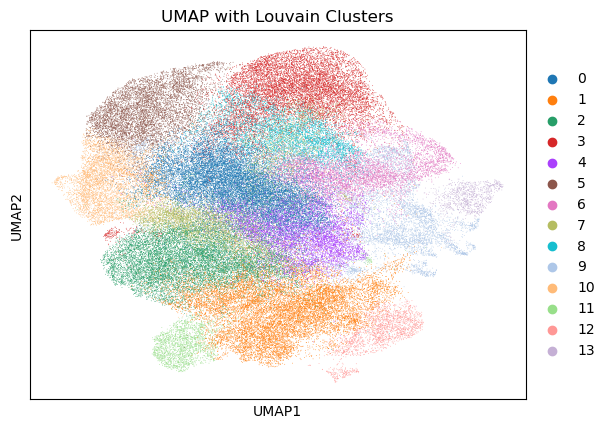

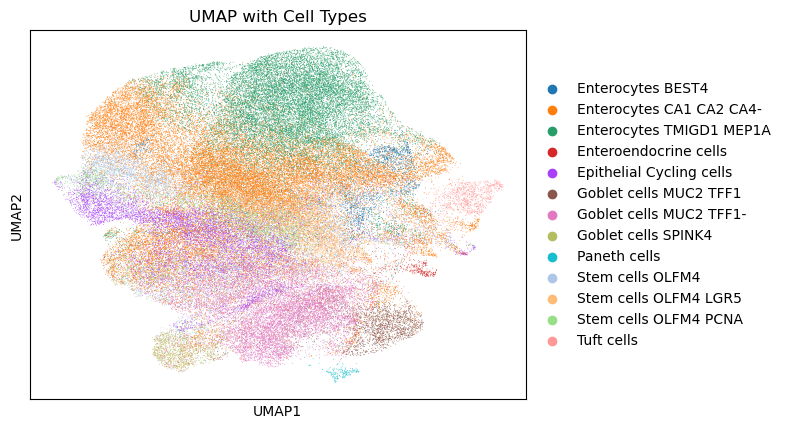

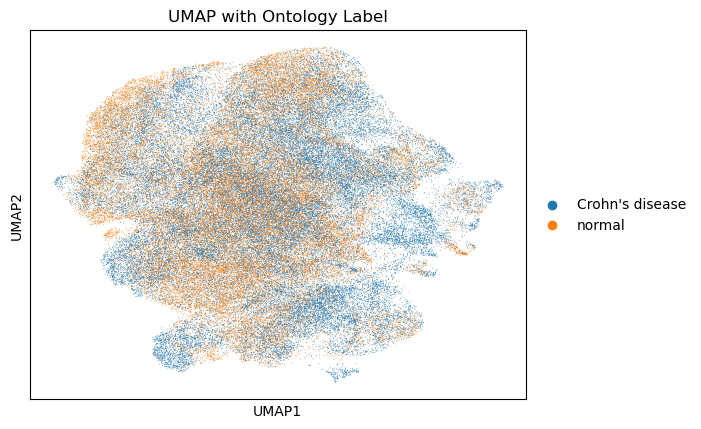

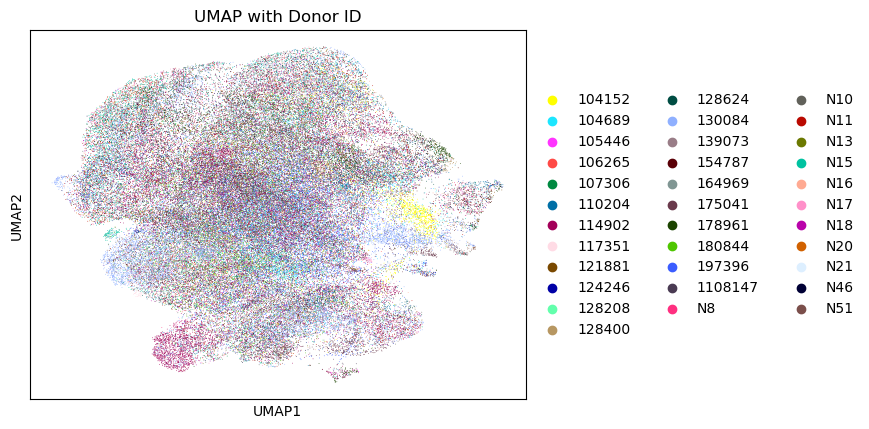

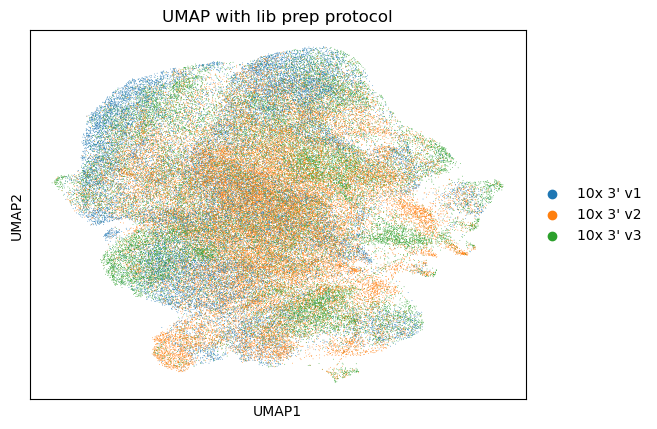

In [29]:
# Plot the clusters
sc.pl.umap(CO_EPI_adata, color="louvain", title="UMAP with Louvain Clusters")
sc.pl.umap(CO_EPI_adata, color="Celltype", title="UMAP with Cell Types")

# Plot the clusters
sc.pl.umap(CO_EPI_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_EPI_adata, color="donor_id", title="UMAP with Donor ID")
sc.pl.umap(CO_EPI_adata, color="library_preparation_protocol__ontology_label", title="UMAP with lib prep protocol")

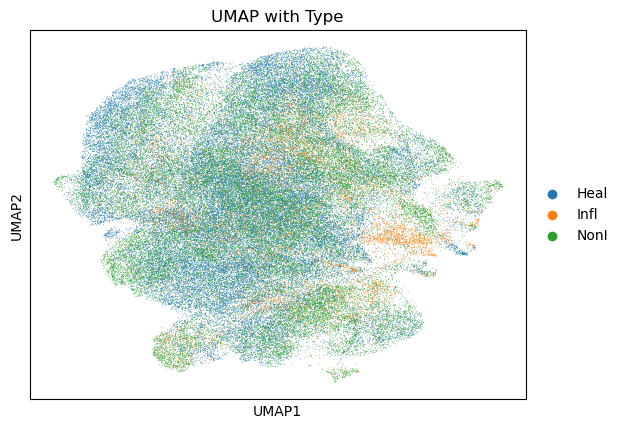

In [20]:
sc.pl.umap(CO_EPI_adata, color="Type", title="UMAP with Type")


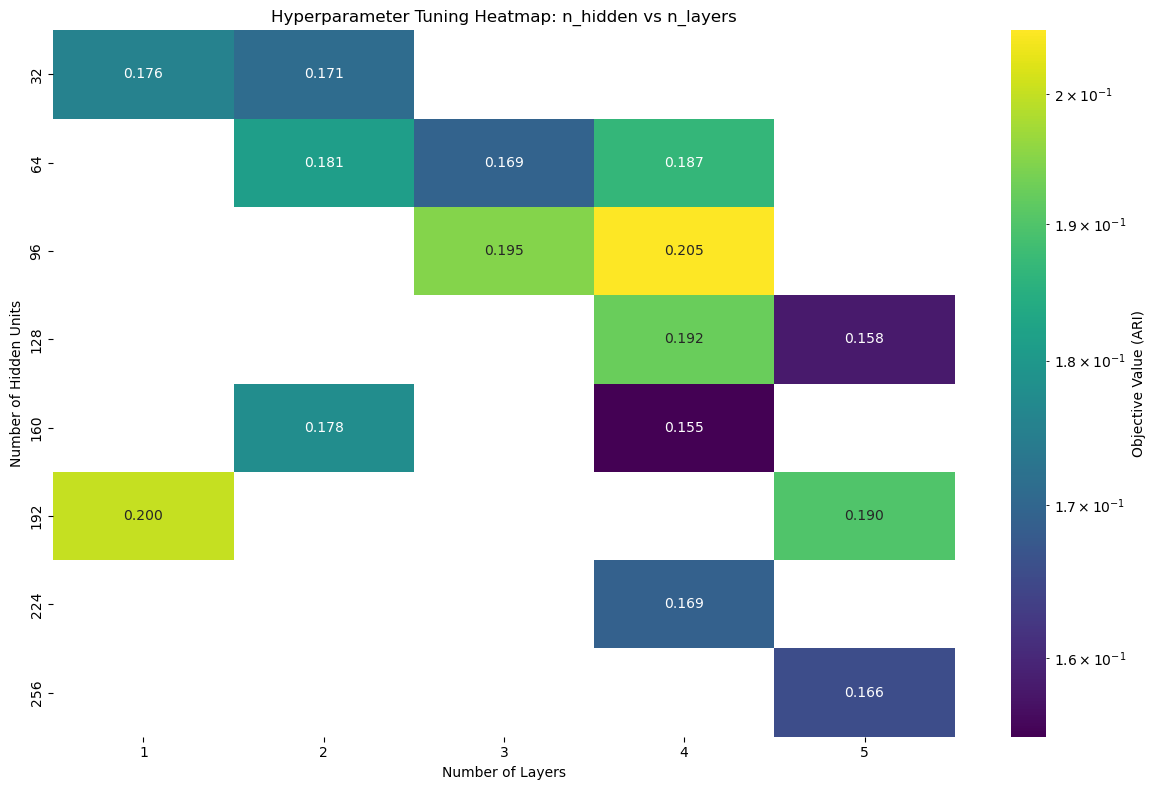

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract data from the Optuna study
data = [
    {
        "n_hidden": trial.params["n_hidden"],
        "n_layers": trial.params["n_layers"],
        "objective_value": trial.value
    }
    for trial in CO_EPI_study.trials if trial.value is not None
]

# Convert to a DataFrame
df = pd.DataFrame(data)

# Create a pivot table for the heatmap (e.g., n_hidden vs n_layers)
heatmap_data = df.pivot_table(
    index="n_hidden",  # Rows
    columns="n_layers",  # Columns
    values="objective_value",  # Heatmap values
    aggfunc="mean"  # If duplicates exist, take the average
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="viridis",
    cbar_kws={"label": "Objective Value (ARI)"},
    norm=LogNorm()  # Optional: Logarithmic scale for objective values
)
plt.title("Hyperparameter Tuning Heatmap: n_hidden vs n_layers")
plt.xlabel("Number of Layers")
plt.ylabel("Number of Hidden Units")
plt.tight_layout()
plt.show()


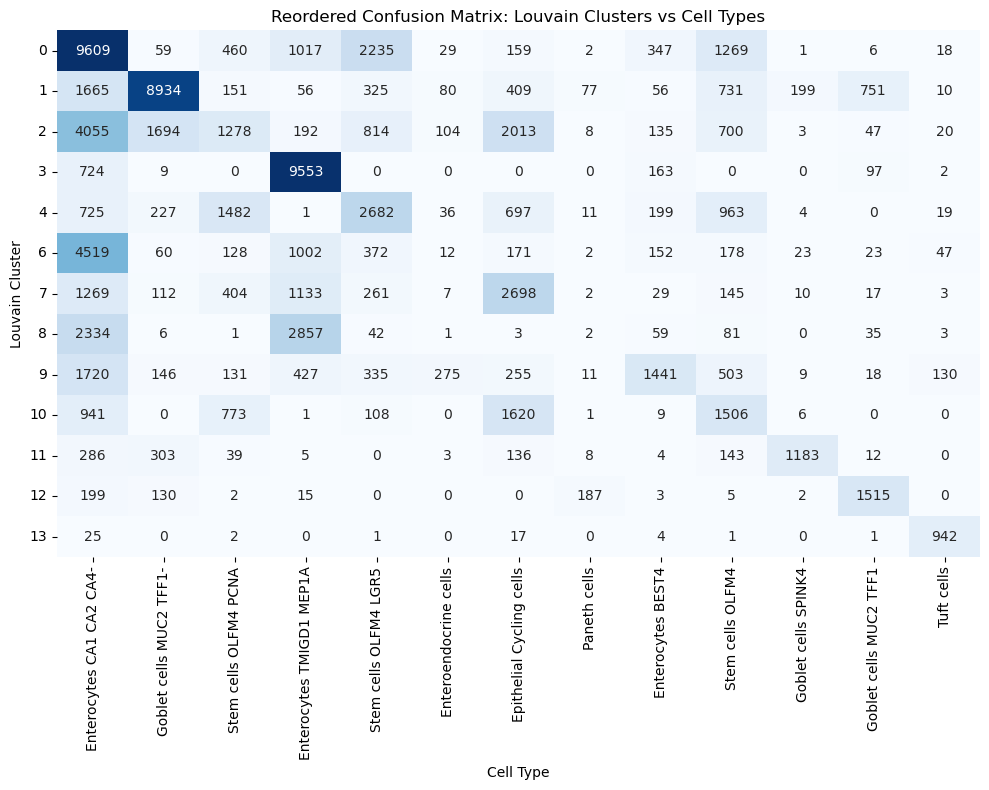

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Create the confusion matrix
conf_matrix = pd.crosstab(CO_EPI_adata.obs["louvain"], CO_EPI_adata.obs["Celltype"], rownames=["Louvain Cluster"], colnames=["Cell Type"])

# Convert to a numpy array for optimization
matrix = conf_matrix.values

# Use the Hungarian algorithm to find the best alignment
# (linear_sum_assignment minimizes cost, so use negative values for maximization)
row_ind, col_ind = linear_sum_assignment(-matrix)

# Reorder rows and columns of the confusion matrix
ordered_conf_matrix = conf_matrix.iloc[row_ind, col_ind]

# Plot the reordered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Reordered Confusion Matrix: Louvain Clusters vs Cell Types")
plt.xlabel("Cell Type")
plt.ylabel("Louvain Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [6]:

from sklearn.metrics import adjusted_rand_score
import optuna
import scvi
import scanpy as sc
import torch
import copy
import pickle

# Ensure all columns are strings to avoid type issues
CO_IMM_adata.obs["donor_id"] = CO_IMM_adata.obs["donor_id"].astype(str)
CO_IMM_adata.obs["library_preparation_protocol__ontology_label"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["library_preparation_protocol__ontology_label"]).astype('category')
CO_IMM_adata.obs["library_preparation_protocol__ontology_label"] = CO_IMM_adata.obs["library_preparation_protocol__ontology_label"].astype(str)

# Create a composite batch column
CO_IMM_adata.obs["batch"] = CO_IMM_adata.obs["donor_id"] + "_" + CO_IMM_adata.obs["library_preparation_protocol__ontology_label"]

def objective(trial):
    # Create a copy of the original AnnData object for this trial
    adata = copy.deepcopy(CO_IMM_adata)
    
    # Suggest hyperparameters
    n_hidden = trial.suggest_int("n_hidden", 32, 256, step=32)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    # latent_dim = trial.suggest_int("latent_dim", 5, 50)
    # lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    
    # Set up scVI with the suggested batch size
    scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

    # Initialize the SCVI model with the suggested parameters
    vae = scvi.model.SCVI(
        adata,
        n_latent=5,
        n_hidden=n_hidden,
        n_layers=n_layers
    )
    
    # Train the model
    scvi.settings.dl_num_workers = 0  # For Windows compatibility
    scvi.settings.dl_persistent_workers = False
    vae.train(
        max_epochs=100,
        plan_kwargs={"lr": 0.0001184620238284258},
        accelerator="gpu",
        early_stopping=True,
        early_stopping_monitor="elbo_train",  # Monitor evidence lower bound
        early_stopping_patience=10  # Stop if no improvement after 10 epochs
    )
    
    # Evaluate clustering quality using Adjusted Rand Index (ARI)
    adata.uns.pop("neighbors", None)  # Reset neighbors
    adata.obsm.pop("X_umap", None)  # Reset UMAP if it exists
    latent = vae.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.louvain(adata, resolution=0.5)
    
    # Drop NaN values for ARI calculation
    valid_cells = ~adata.obs["Celltype"].isna()
    ari = adjusted_rand_score(
        adata.obs["Celltype"][valid_cells],
        adata.obs["louvain"][valid_cells]
    )
    
    return ari  # Maximize ARI


# Run the hyperparameter optimization
CO_IMM_study = optuna.create_study(direction="maximize")
CO_IMM_study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Print the best hyperparameters
best_params = CO_IMM_study.best_params
print("Best hyperparameters:", best_params)

# Save the study to a pickle file
with open("CO_IMM_study_combined_batch_tuned.pkl", "wb") as f:
    pickle.dump(CO_IMM_study, f)

# Set up scVI with the best parameters
scvi.model.SCVI.setup_anndata(CO_IMM_adata, batch_key="batch")

# Train the final model with the best parameters
CO_IMM_tuned_vae = scvi.model.SCVI(
    CO_IMM_adata,
    n_latent=5,
    n_hidden=best_params["n_hidden"],
    n_layers=best_params["n_layers"]
)
CO_IMM_tuned_vae.train(
    max_epochs=400,
    plan_kwargs={"lr": 0.0001184620238284258},
    accelerator="gpu"
)
CO_IMM_tuned_vae.save("CO_IMM_combined_batch_tuned.model", overwrite=True)


[I 2024-12-08 19:32:04,543] A new study created in memory with name: no-name-46c9c428-5041-45da-98f2-6de4cb22831d
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-08 20:34:57,952] Trial 0 finished with value: 0.30420500338849515 and parameters: {'n_hidden': 256, 'n_layers': 5}. Best is trial 0 with value: 0.30420500338849515.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-08 21:26:04,291] Trial 1 finished with value: 0.30132987739715794 and parameters: {'n_hidden': 64, 'n_layers': 4}. Best is trial 0 with value: 0.30420500338849515.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-08 22:20:15,860] Trial 2 finished with value: 0.3043392590632697 and parameters: {'n_hidden': 96, 'n_layers': 4}. Best is trial 2 with value: 0.3043392590632697.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-08 23:12:49,328] Trial 3 finished with value: 0.3020567500170392 and parameters: {'n_hidden': 64, 'n_layers': 3}. Best is trial 2 with value: 0.3043392590632697.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 00:02:20,239] Trial 4 finished with value: 0.20871205359932118 and parameters: {'n_hidden': 32, 'n_layers': 4}. Best is trial 2 with value: 0.3043392590632697.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 00:57:05,389] Trial 5 finished with value: 0.2861855352444252 and parameters: {'n_hidden': 96, 'n_layers': 3}. Best is trial 2 with value: 0.3043392590632697.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 01:55:40,851] Trial 6 finished with value: 0.33986888365187823 and parameters: {'n_hidden': 192, 'n_layers': 3}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 02:43:44,454] Trial 7 finished with value: 0.2493619135061756 and parameters: {'n_hidden': 32, 'n_layers': 2}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 03:44:40,272] Trial 8 finished with value: 0.2909719383784429 and parameters: {'n_hidden': 256, 'n_layers': 3}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 04:33:53,918] Trial 9 finished with value: 0.28105356379305063 and parameters: {'n_hidden': 64, 'n_layers': 1}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 05:27:01,944] Trial 10 finished with value: 0.2892405013037375 and parameters: {'n_hidden': 192, 'n_layers': 1}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 06:21:36,987] Trial 11 finished with value: 0.3284592029782555 and parameters: {'n_hidden': 160, 'n_layers': 5}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 07:17:22,955] Trial 12 finished with value: 0.3160199553970167 and parameters: {'n_hidden': 192, 'n_layers': 5}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 08:10:09,745] Trial 13 finished with value: 0.30668985004676214 and parameters: {'n_hidden': 160, 'n_layers': 2}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 09:03:58,882] Trial 14 finished with value: 0.28988375575430536 and parameters: {'n_hidden': 192, 'n_layers': 2}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 09:58:35,846] Trial 15 finished with value: 0.2783561854265908 and parameters: {'n_hidden': 160, 'n_layers': 5}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 10:55:49,796] Trial 16 finished with value: 0.3069304011126432 and parameters: {'n_hidden': 224, 'n_layers': 4}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 11:47:53,999] Trial 17 finished with value: 0.31377726128021965 and parameters: {'n_hidden': 128, 'n_layers': 2}. Best is trial 6 with value: 0.33986888365187823.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 12:40:10,250] Trial 18 finished with value: 0.3869153427196985 and parameters: {'n_hidden': 128, 'n_layers': 3}. Best is trial 18 with value: 0.3869153427196985.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-12-09 13:31:42,356] Trial 19 finished with value: 0.35851513908356986 and parameters: {'n_hidden': 128, 'n_layers': 3}. Best is trial 18 with value: 0.3869153427196985.


Best hyperparameters: {'n_hidden': 128, 'n_layers': 3}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [7]:
# Extract the latent space representation for each cell
CO_IMM_latent_representation = CO_IMM_tuned_vae.get_latent_representation()
CO_IMM_adata.obsm["X_scVI"] = CO_IMM_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_IMM_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_IMM_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_IMM_adata)


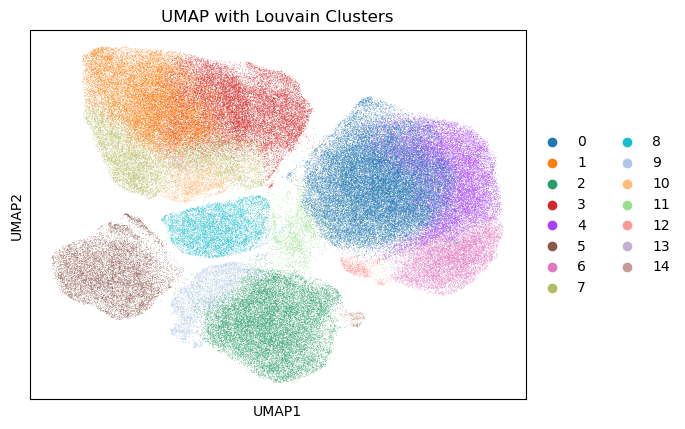

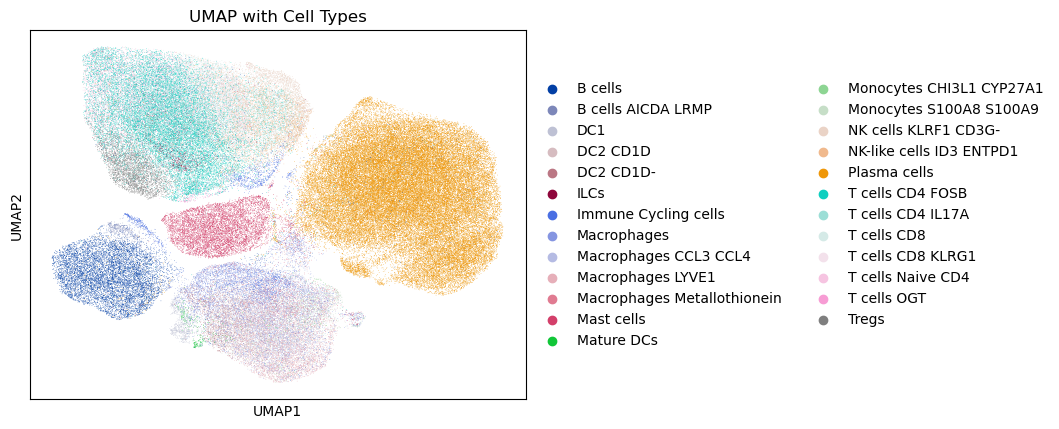

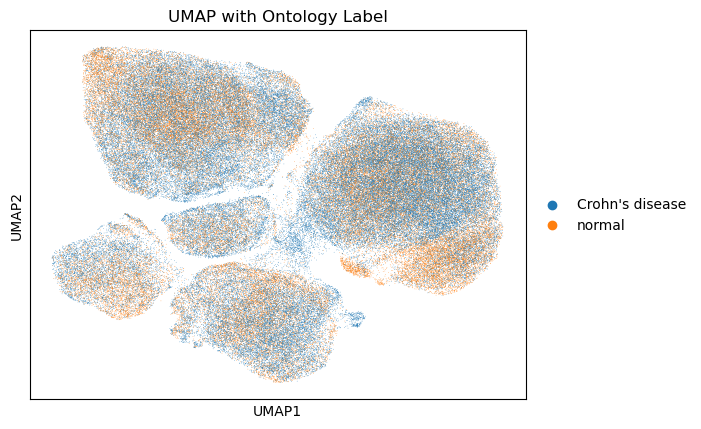

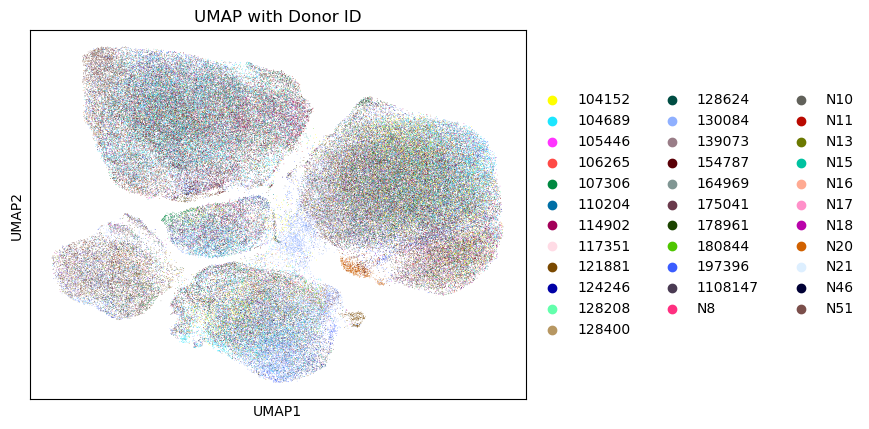

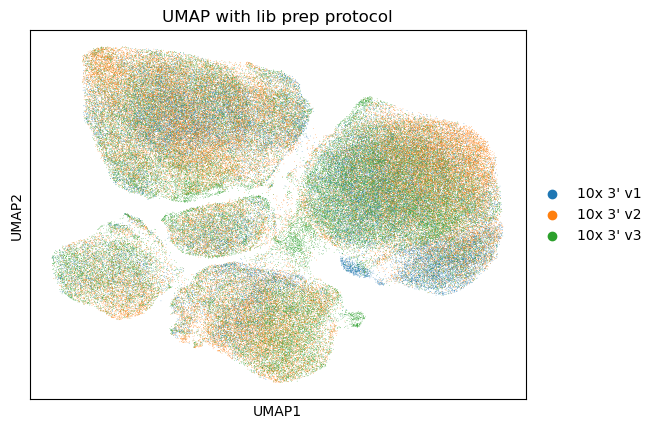

In [8]:
# Plot the clusters
sc.pl.umap(CO_IMM_adata, color="louvain", title="UMAP with Louvain Clusters")
sc.pl.umap(CO_IMM_adata, color="Celltype", title="UMAP with Cell Types")

# Plot the clusters
sc.pl.umap(CO_IMM_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_IMM_adata, color="donor_id", title="UMAP with Donor ID")
sc.pl.umap(CO_IMM_adata, color="library_preparation_protocol__ontology_label", title="UMAP with lib prep protocol")

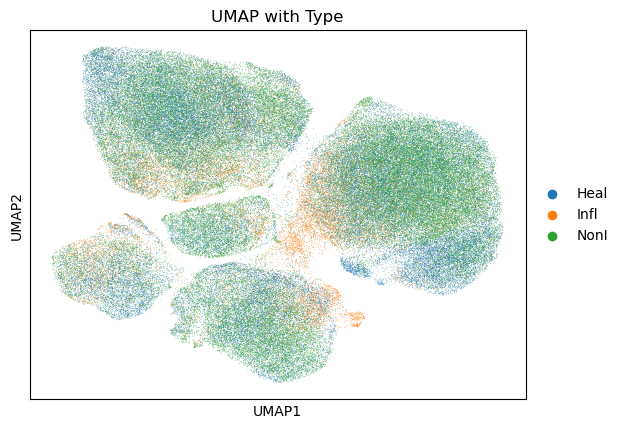

In [15]:
sc.pl.umap(CO_IMM_adata, color="Type", title="UMAP with Type")


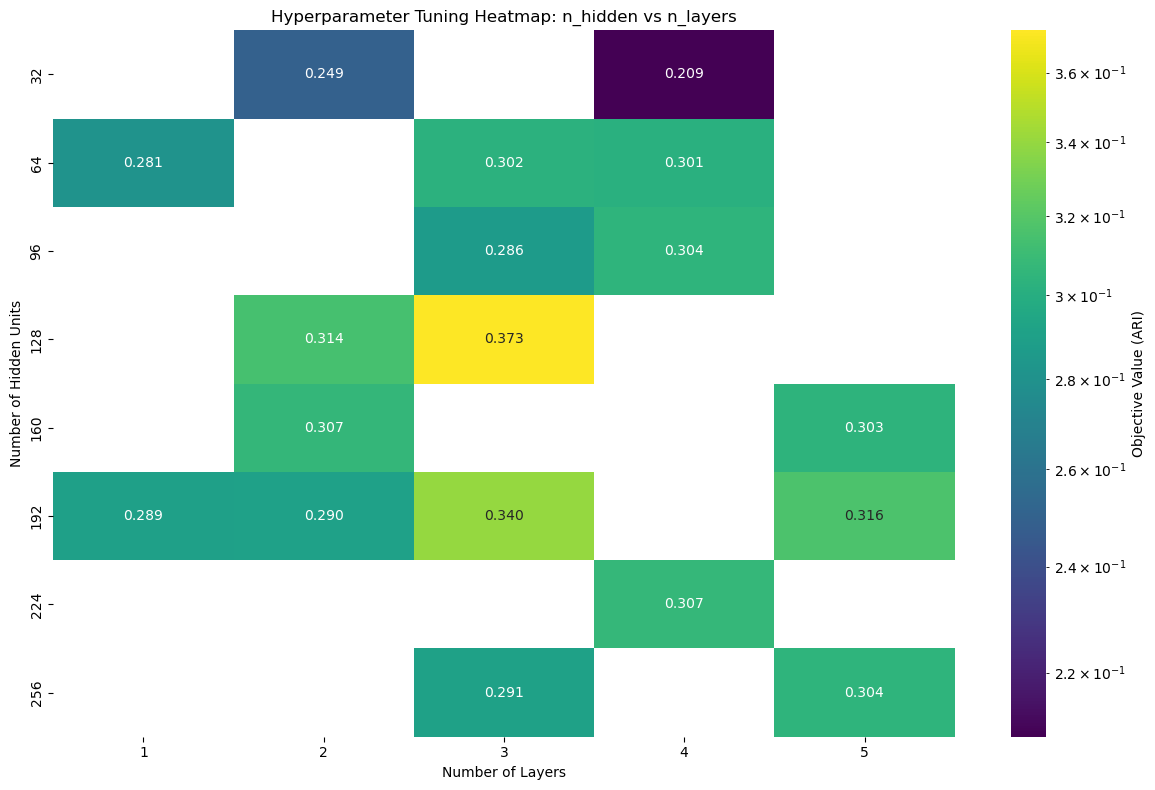

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Extract data from the Optuna study
data = [
    {
        "n_hidden": trial.params["n_hidden"],
        "n_layers": trial.params["n_layers"],
        "objective_value": trial.value
    }
    for trial in CO_IMM_study.trials if trial.value is not None
]

# Convert to a DataFrame
df = pd.DataFrame(data)

# Create a pivot table for the heatmap (e.g., n_hidden vs n_layers)
heatmap_data = df.pivot_table(
    index="n_hidden",  # Rows
    columns="n_layers",  # Columns
    values="objective_value",  # Heatmap values
    aggfunc="mean"  # If duplicates exist, take the average
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".3f", cmap="viridis",
    cbar_kws={"label": "Objective Value (ARI)"},
    norm=LogNorm()  # Optional: Logarithmic scale for objective values
)
plt.title("Hyperparameter Tuning Heatmap: n_hidden vs n_layers")
plt.xlabel("Number of Layers")
plt.ylabel("Number of Hidden Units")
plt.tight_layout()
plt.show()


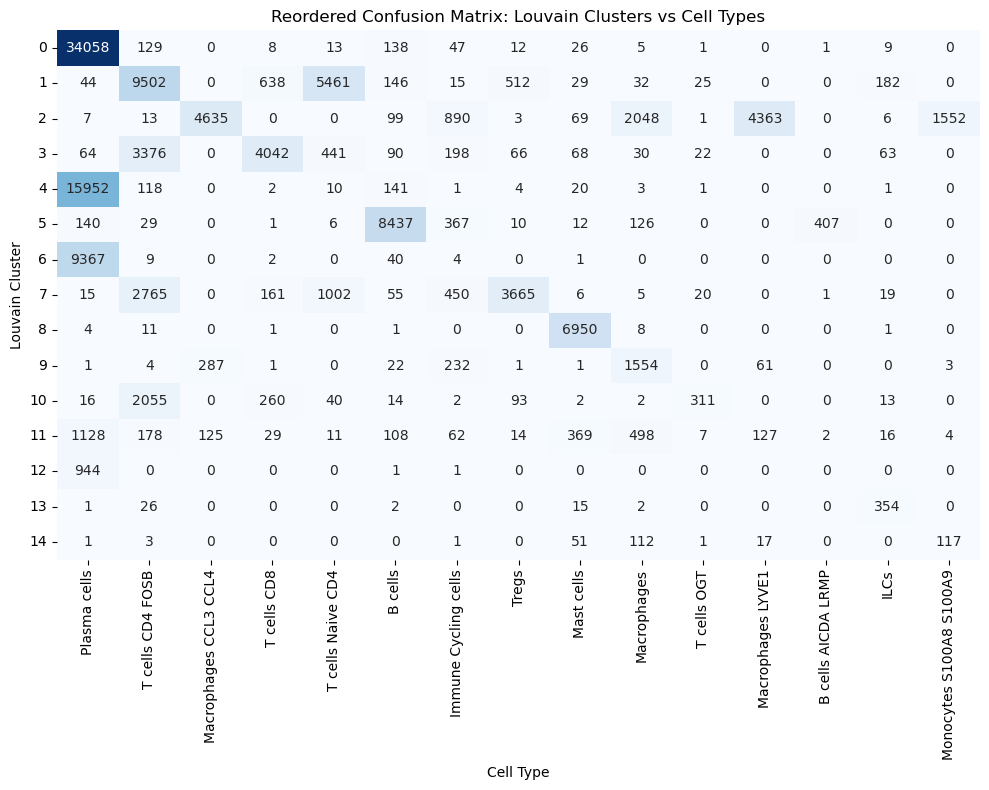

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Create the confusion matrix
conf_matrix = pd.crosstab(CO_IMM_adata.obs["louvain"], CO_IMM_adata.obs["Celltype"], rownames=["Louvain Cluster"], colnames=["Cell Type"])

# Convert to a numpy array for optimization
matrix = conf_matrix.values

# Use the Hungarian algorithm to find the best alignment
# (linear_sum_assignment minimizes cost, so use negative values for maximization)
row_ind, col_ind = linear_sum_assignment(-matrix)

# Reorder rows and columns of the confusion matrix
ordered_conf_matrix = conf_matrix.iloc[row_ind, col_ind]

# Plot the reordered confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Reordered Confusion Matrix: Louvain Clusters vs Cell Types")
plt.xlabel("Cell Type")
plt.ylabel("Louvain Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
import scanpy as sc

# Log-transform the data in a temporary AnnData object
temp_adata = CO_STR_adata.copy()
sc.pp.log1p(temp_adata)

# Assign the log-transformed data to .raw for Hack to use log data without altering original data
CO_STR_adata.raw = temp_adata

In [20]:

# Subset the data by disease
fibro_heal_adata = CO_STR_adata[CO_STR_adata.obs["Type"] == "Heal"].copy()
fibro_noni_adata = CO_STR_adata[CO_STR_adata.obs["Type"] == "NonI"].copy()
fibro_infl_adata = CO_STR_adata[CO_STR_adata.obs["Type"] == "Infl"].copy()

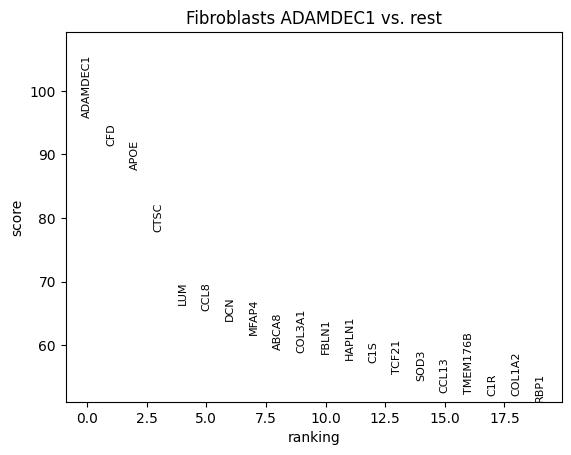

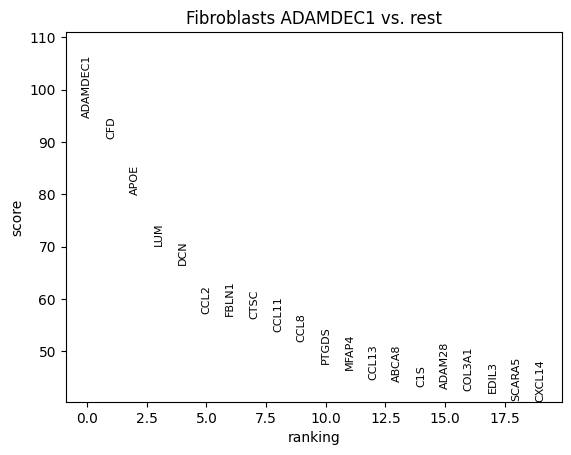

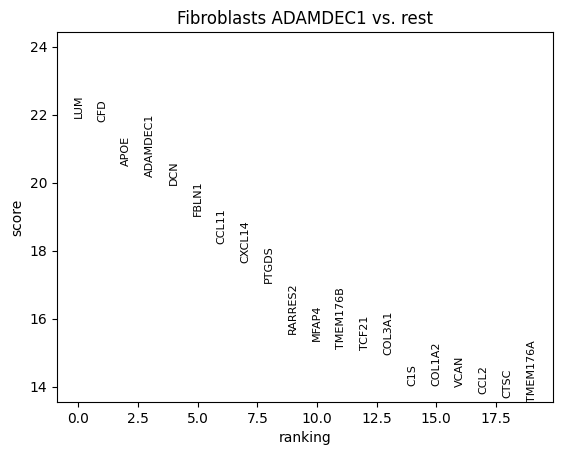

In [24]:
import mygene
import numpy as np
import scanpy as sc

# Initialize mygene API
mg = mygene.MyGeneInfo()

def replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(adata, n_top=20):
    """
    Replace Ensembl IDs with gene symbols in adata.uns["rank_genes_groups"]["names"] while retaining the original structure.
    """
    # Extract the rank_genes_groups names
    ranked_genes = adata.uns["rank_genes_groups"]["names"]

    # Check the structure of the ranked_genes array
    if not isinstance(ranked_genes, np.ndarray):
        raise ValueError("adata.uns['rank_genes_groups']['names'] must be a NumPy array.")

    # Flatten and extract gene names from the structured array
    ranked_genes_flat = [gene[0] for gene in ranked_genes]

    # Get unique top genes
    top_genes = np.unique(ranked_genes_flat[:n_top])

    # Query mygene for corresponding gene symbols
    query_results = mg.querymany(
        list(top_genes), scopes="ensembl.gene", fields="symbol", species="human"
    )

    # Create a mapping of Ensembl IDs to gene symbols
    ensembl_to_symbol = {result["query"]: result.get("symbol", result["query"]) for result in query_results}

    # Replace names with symbols
    updated_ranked_genes = [
        (ensembl_to_symbol.get(gene, gene),) for gene in ranked_genes_flat
    ]

    # Convert back to structured array with the same dtype
    updated_ranked_genes = np.array(updated_ranked_genes, dtype=ranked_genes.dtype)

    # Update adata.uns["rank_genes_groups"]["names"]
    adata.uns["rank_genes_groups"]["names"] = updated_ranked_genes

    
    
    
    
# Perform DE analysis for "Healthy"
sc.tl.rank_genes_groups(
    fibro_heal_adata,
    groupby="Celltype",
    groups=["Fibroblasts ADAMDEC1"],  # Test clusters
    reference="rest",  # Compare against all other clusters
    method="wilcoxon",  # Use Wilcoxon rank-sum test
    use_raw=True,  # Use the raw data for DE analysis
)
replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(fibro_heal_adata, n_top=20)

# Perform DE analysis for "Non-Inflamed"
sc.tl.rank_genes_groups(
    fibro_noni_adata,
    groupby="Celltype",
    groups=["Fibroblasts ADAMDEC1"],  # Test clusters
    reference="rest",  # Compare against all other clusters
    method="wilcoxon",  # Use Wilcoxon rank-sum test
    use_raw=True,  # Use the raw data for DE analysis
)        
replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(fibro_noni_adata, n_top=20)

# Perform DE analysis for "Inflamed"
sc.tl.rank_genes_groups(
    fibro_infl_adata,
    groupby="Celltype",
    groups=["Fibroblasts ADAMDEC1"],  # Test clusters
    reference="rest",  # Compare against all other clusters
    method="wilcoxon",  # Use Wilcoxon rank-sum test
    use_raw=True,  # Use the raw data for DE analysis
)
replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(fibro_infl_adata, n_top=20)

# Plot the results for "Healthy"
sc.pl.rank_genes_groups(fibro_heal_adata, n_genes=20, sharey=False, title="Healthy")

# Plot the results for "Non-Inflamed"
sc.pl.rank_genes_groups(fibro_noni_adata, n_genes=20, sharey=False, title="Non-Inflamed")

# Plot the results for "Inflamed"
sc.pl.rank_genes_groups(fibro_infl_adata, n_genes=20, sharey=False, title="Inflamed")


In [25]:
# Subset the data by disease
louvain_heal_adata = CO_STR_adata[CO_STR_adata.obs["Type"] == "Heal"].copy()
louvain_noni_adata = CO_STR_adata[CO_STR_adata.obs["Type"] == "NonI"].copy()
louvain_infl_adata = CO_STR_adata[CO_STR_adata.obs["Type"] == "Infl"].copy()

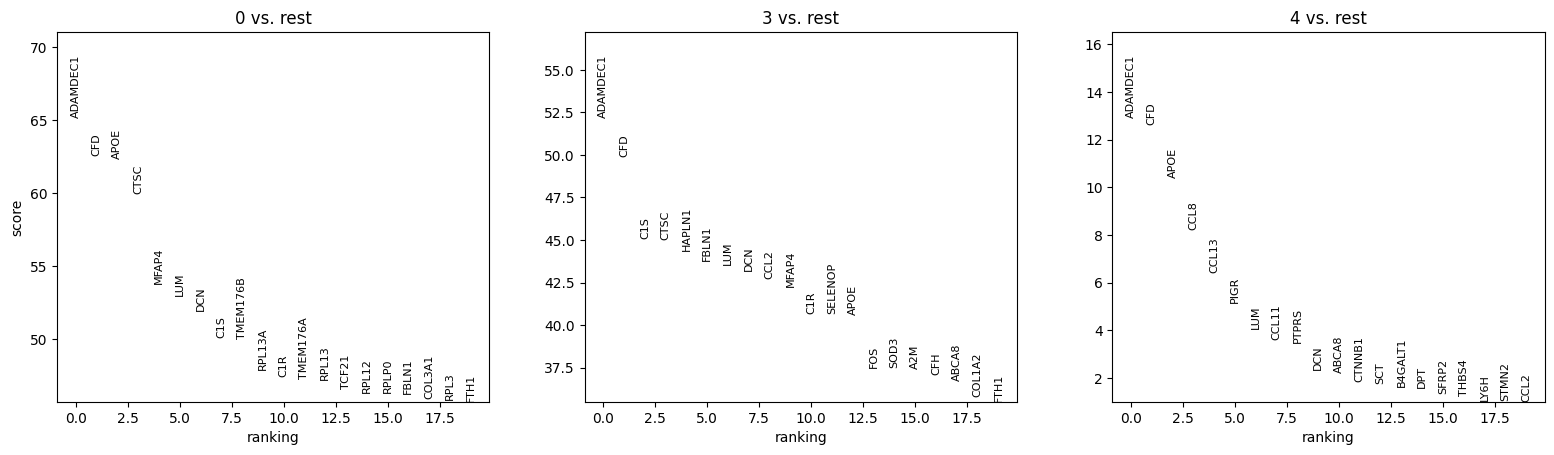

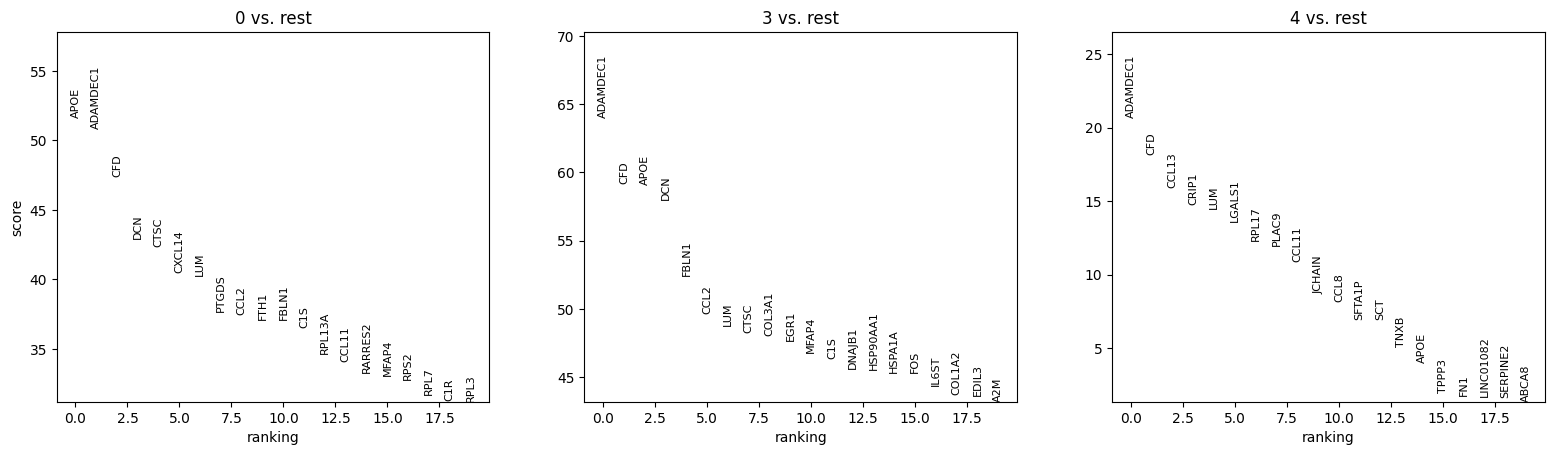

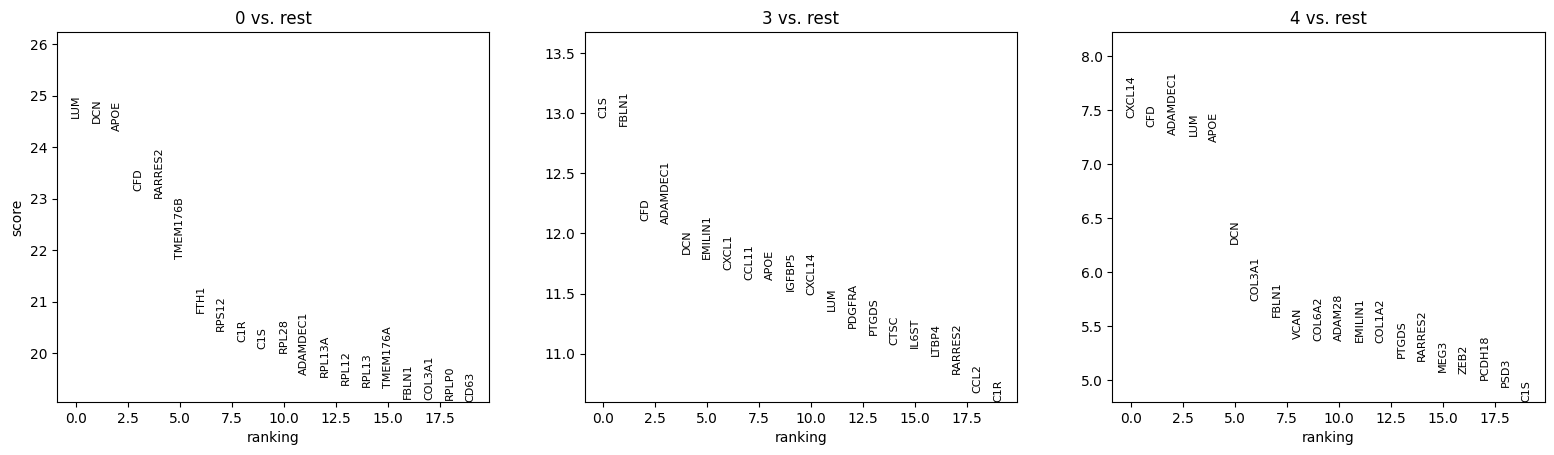

In [27]:
import mygene
import numpy as np
import scanpy as sc

# Initialize mygene API
mg = mygene.MyGeneInfo()

def replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(adata, n_top=20):
    """
    Replace Ensembl IDs with gene symbols in adata.uns["rank_genes_groups"]["names"] for multiple groups.
    """
    # Extract the rank_genes_groups names
    ranked_genes = adata.uns["rank_genes_groups"]["names"]

    # Check if ranked_genes is structured correctly
    if not isinstance(ranked_genes, np.ndarray):
        raise ValueError("adata.uns['rank_genes_groups']['names'] must be a NumPy array.")

    # Iterate over fields (clusters 0, 3, 4) in the structured array
    updated_ranked_genes = {}
    for cluster in ranked_genes.dtype.names:
        # Flatten and extract gene names for this cluster
        ranked_genes_flat = ranked_genes[cluster][:n_top]  # Get top n genes

        # Query mygene for corresponding gene symbols
        query_results = mg.querymany(
            list(ranked_genes_flat), scopes="ensembl.gene", fields="symbol", species="human"
        )

        # Create a mapping of Ensembl IDs to gene symbols
        ensembl_to_symbol = {result["query"]: result.get("symbol", result["query"]) for result in query_results}

        # Replace names with symbols
        updated_ranked_genes[cluster] = [
            ensembl_to_symbol.get(gene, gene) for gene in ranked_genes_flat
        ]

    # Convert updated genes into a structured array
    structured_array = np.zeros_like(ranked_genes, dtype=ranked_genes.dtype)
    for cluster in updated_ranked_genes:
        structured_array[cluster][:n_top] = updated_ranked_genes[cluster]

    # Update adata.uns["rank_genes_groups"]["names"]
    adata.uns["rank_genes_groups"]["names"] = structured_array


# Perform DE analysis for "Healthy"
sc.tl.rank_genes_groups(
    louvain_heal_adata,
    groupby="louvain",
    groups=["0", "3", "4"],  # Test clusters
    reference="rest",  # Compare against all other clusters
    method="wilcoxon",  # Use Wilcoxon rank-sum test
    use_raw=True,  # Use the raw data for DE analysis
)

# Replace Ensembl IDs with symbols for "Healthy"
replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(louvain_heal_adata, n_top=20)

# Perform DE analysis for "Non-Inflamed's disease"
sc.tl.rank_genes_groups(
    louvain_noni_adata,
    groupby="louvain",
    groups=["0", "3", "4"],  # Test clusters
    reference="rest",  # Compare against all other clusters
    method="wilcoxon",  # Use Wilcoxon rank-sum test
    use_raw=True,  # Use the raw data for DE analysis
)

# Replace Ensembl IDs with symbols for "Non-Inflamed"
replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(louvain_noni_adata, n_top=20)

# Perform DE analysis for "Inflamed's disease"
sc.tl.rank_genes_groups(
    louvain_infl_adata,
    groupby="louvain",
    groups=["0", "3", "4"],  # Test clusters
    reference="rest",  # Compare against all other clusters
    method="wilcoxon",  # Use Wilcoxon rank-sum test
    use_raw=True,  # Use the raw data for DE analysis
)

# Replace Ensembl IDs with symbols for "Inflamed"
replace_top_ranked_ensembl_with_symbols_in_rank_genes_groups(louvain_infl_adata, n_top=20)


# Plot the results for "Healthy"
sc.pl.rank_genes_groups(louvain_heal_adata, n_genes=20, sharey=False, title="Healthy")

# Plot the results for "Non-Inflamed"
sc.pl.rank_genes_groups(louvain_noni_adata, n_genes=20, sharey=False, title="Non-Inflamed")

# Plot the results for "Inflamed"
sc.pl.rank_genes_groups(louvain_infl_adata, n_genes=20, sharey=False, title="Inflamed")
